In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import Counter

dvc = 'cpu'
rndSeed = 42
trRatio = 0.8
devRatio = 0.9
contextSize = 3
embeddingDims = 10
hiddenLayerSize = 300
trainingBatchSize = 32
rndSeed2 = 2147483647
g = torch.Generator(device=dvc).manual_seed(rndSeed2)
gSampling = torch.Generator(device=dvc).manual_seed(rndSeed2 + 10)

words = readFileSplitByLine('sk-names.txt')
random.seed(rndSeed)
random.shuffle(words)
print('first few words:\t', words[:5])

lenWords = len(words);
print('lenWords:\t', lenWords)

allPossibleChars = sorted(list(set(''.join(words))))
print('allPossibleChars:\t', allPossibleChars)

stoi = sToI(allPossibleChars)
print('stoi:\t', stoi)

itos = iToS(stoi)
print('itos:\t', itos)

vocabularyLength = len(itos)
print('vocabularyLength:\t', vocabularyLength)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dvc)
print('data set training:\t', lenTrain, trX.shape, trY.shape, trWords[:3])

endDev = int(devRatio * lenWords)
devWords = words[lenTrain:endDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos, dvc)
print('data set dev:\t', endDev - lenTrain, devX.shape, devY.shape, devWords[:3])

lenTest = lenWords - endDev
tstWords = words[endDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dvc)
print('data set test:\t', lenTest, tstX.shape, tstY.shape, tstWords[:3])

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
print('parametersCount:\t', sum(p.nelement() for p in np.all))

print(f'random probability:\t {-torch.tensor(1 / vocabularyLength).log().item():.4f}')

#@torch.no_grad()
def trLoss(): return getLoss(np, np.C[trX], trY)

#@torch.no_grad()
def devLoss(): return getLoss(np, np.C[devX], devY)

#@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[tstX], tstY)

class Losses:
    tr: Loss
    dev: Loss
    tst: Loss

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.dev = devLoss()
    l.tst = tstLoss()
    return l

def printLosses():
    losses = getLosses()
    l1 = f'{losses.tr.loss.item():>10.4f}'
    l2 = f'{losses.dev.loss.item():>10.4f}'
    l3 = f'{losses.tst.loss.item():>10.4f}'
    print(f'{l1} {l2} {l3}')

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
print ('trainingSteps: \t', trainingSteps)

lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr: ForwardPassResult = ForwardPassResult()
fr.loss = torch.tensor(0)

i = 0
for repeat in range(20):
    
    print(f'{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ', end='')
    printLosses()

    for start in range(0, trXLength, trainingBatchSize):
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, trX, trY, miniBatchIxs)
        
        backwardPass(np.all, fr.loss)
        
        updateNet(np.all, i, lr)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())

        #if repeat == 0 and i % (trainingBatchSize * 10) == 0:
        #    print(f'{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ')

        if i % 10_000 == 0:
            print(f'{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ')

        #if i > 200_000:
        #    print('break')
        #    break;
        
        i += 1

printLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#print('best learning rate:\t', bestLr)
print('emb.shape:\t', fr.emb.shape)
print('h.shape:\t', fr.h.shape)
print('logits.shape:\t', fr.logits.shape)



first few words:	 ['Miida', 'Gaivile', 'Neta', 'Honorát', 'Evyenous']
lenWords:	 3018
allPossibleChars:	 [' ', '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'Ü', 'á', 'ä', 'é', 'í', 'ó', 'ö', 'ú', 'ü', 'ý', 'Č', 'č', 'ě', 'ľ', 'Ł', 'ł', 'ň', 'Ő', 'ő', 'ř', 'Š', 'š', 'Ž', 'ž']
stoi:	 {' ': 1, '-': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'R': 19, 'S': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27, 'a': 28, 'b': 29, 'c': 30, 'd': 31, 'e': 32, 'f': 33, 'g': 34, 'h': 35, 'i': 36, 'j': 37, 'k': 38, 'l': 39, 'm': 40, 'n': 41, 'o': 42, 'p': 43, 'q': 44, 'r': 45, 's': 46, 't': 47, 'u': 48, 'v': 49, 'w': 50, 'x': 51, 'y': 52, 'z': 53, 'Á': 54, 'É': 55, 'Ü': 

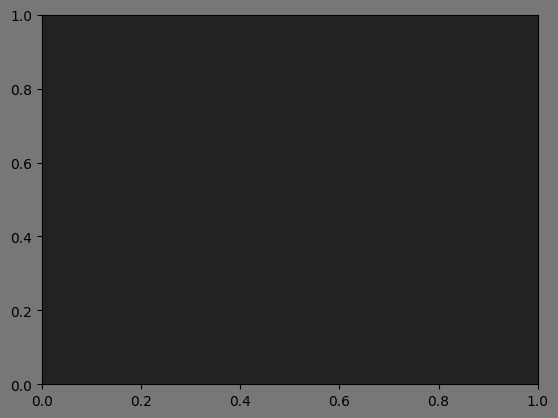

In [3]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
#ax.plot(lrAtIx, lossAtIx)
plt.show()

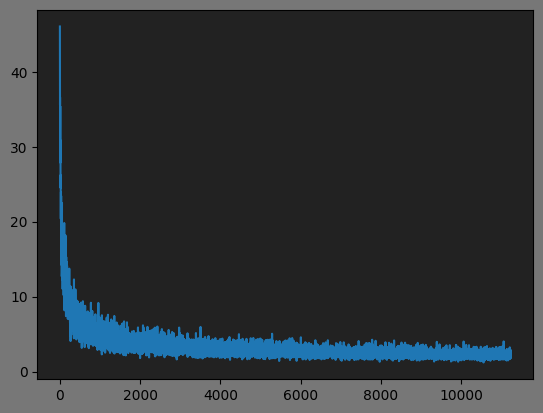

In [4]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, lossAtIx)
plt.show()

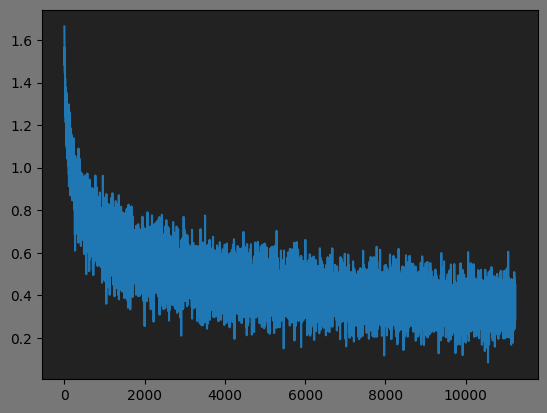

In [5]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, logLossAtIx)
plt.show()

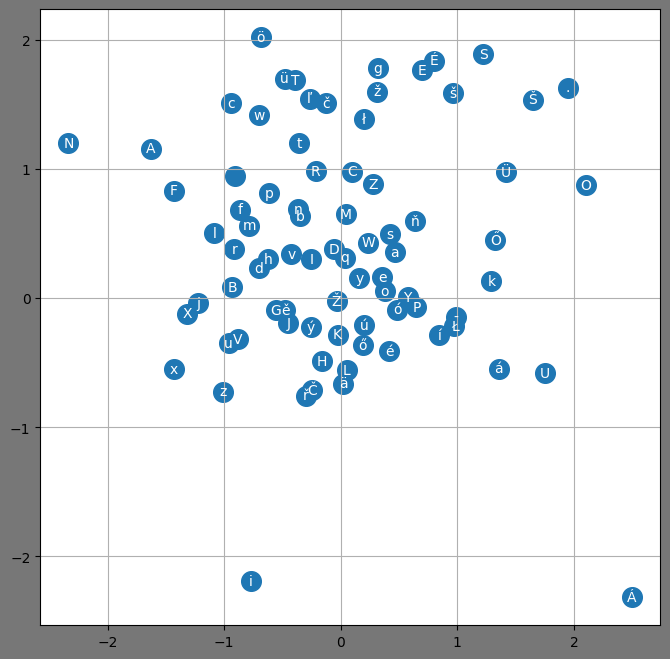

In [6]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('#777777')
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [11]:
samples = sample(np, gSampling, contextSize, itos, 20)
for s in samples:
    print(''.join(s.values) + '  ', end='')
    for p in [s.prob] + s.probs:
        print(f'{(p * 100):.0f} ', end='')
    print()

Zigu.  110767 28 645 1866 2045 792 
Aimette.  5029025 234 81 957 2193 430 54 1670 2611 
Doofasia.  324757551 144 815 52 1620 1673 573 871 1445 2450 
Theo.  790326 205 961 1777 2077 543 
Alfréd.  1906554 234 726 43 2563 182 2594 1516 
Felius.  58206548 500 400 1125 2570 102 2641 2627 
Duchorle.  551211745 144 389 2268 1294 2362 1035 599 373 552 
Mária.  15895127 149 238 2549 2669 1900 2086 
Elna.  875347 131 1361 453 2194 2471 
Areima.  190165 234 292 329 10 2490 938 2434 
Vice.  577203 76 1432 434 2591 2350 
Ppiso.  289325 142 23 1725 2461 648 1922 
Botdaa.  7332 155 525 475 1001 1208 0 2245 
Čestarala.  757533980 4 818 2577 2699 1081 512 428 611 1393 1471 
Iowecoria.  60405834 363 326 104 417 13 1750 1239 1659 1184 2086 
Iduusanstas.  11896363714671 363 883 537 1713 1046 421 1073 746 2546 2661 932 2176 
Fauva.  232112 500 118 969 43 2400 2383 
Fábiuše.  60561192852 500 877 2248 2667 1855 1491 2594 2567 
Fetitiyjeld.  2537214487 500 400 305 2565 307 11 428 177 973 1791 2344 1841 
Feyim

In [12]:
ps = calcProb(np, 'Zigu.', contextSize, stoi)
op = calcOneProb(ps)
for p in [op] + ps:
    print(f'{(p * 100):.0f} ', end='')

110767 28 645 1866 2045 792 

In [9]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([80, 10]),
 torch.Size([17953, 3]),
 torch.Size([17953, 3, 10]),
 tensor([[ 1.9480,  1.6309,  0.4070, -2.1733, -0.0404,  0.5981, -3.8806,  0.5456,
          -0.0629,  1.0586],
         [-0.9093,  0.9491, -0.6038,  0.0935,  1.9511,  3.0650,  1.6871, -1.8626,
           0.1554, -0.2067],
         [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
          -1.2199,  0.3031],
         [-1.6296,  1.1581,  0.2262,  1.3452, -0.8583, -0.3840, -0.6142,  2.0390,
          -1.8988,  1.3661],
         [-0.9332,  0.0835, -0.6604,  0.2154, -1.0944,  0.6243,  0.5555,  1.1285,
          -0.8617, -1.1816]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 36],
         [15, 36, 36],
         [36, 36, 31]]),
 tensor([[[ 1.9480,  1.6309,  0.4070, -2.1733, -0.0404,  0.5981, -3.8806,
            0.5456, -0.0629,  1.0586],
          [ 1.9480,  1.6309,  0.4070, -2.1733, -0.0404,  0.5981, -3.8806,
            0.5456, -0.0629,  1.0586

In [10]:
# Let's suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let's print the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
